In [1]:
import cv2
import glob
import numpy as np
from IPython.display import Image

# Task 2

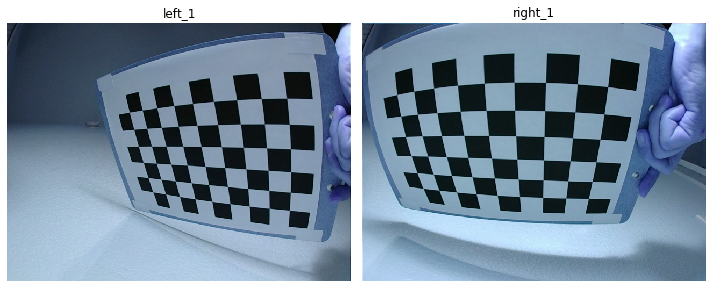

In [2]:
left_ = [cv2.imread(image) for image in glob.glob("../../images/task_1/left_*.png")]
right_ = [cv2.imread(image) for image in glob.glob("../../images/task_1/right_*.png")]

import matplotlib.pyplot as plt
def plot_figures(figures, nrows=1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    if(nrows > 1 or ncols > 1):
        for ind,title in enumerate(figures):
            axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
            axeslist.ravel()[ind].set_title(title)
            axeslist.ravel()[ind].set_axis_off()
        plt.tight_layout() # optional
    else:
        for ind,title in enumerate(figures):
            axeslist.imshow(figures[title], cmap=plt.gray())
            axeslist.set_title(title)
            axeslist.set_axis_off()
            

plot_figures({'left_1': left_[0], 'right_1': right_[0]}, 1, 2)

In [22]:
s = cv2.FileStorage('../task_1/calibrated_camera_parameters.xml', cv2.FileStorage_READ)

In [23]:
s.isOpened()

True

In [26]:
mtx = s.getNode('mtx').mat()
dist = s.getNode('dist').mat()
newcameramtx = s.getNode('newcameramtx').mat()
roi = s.getNode('roi').mat()
roi

array([[144.],
       [131.],
       [467.],
       [302.]])

In [28]:
dist

array([[-0.47346989,  0.25329587, -0.00219312,  0.00187593, -0.0522464 ]])